In [28]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import sklearn as sk
import datetime as dt
from sklearn import model_selection
#from sklearn import cat
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, auc, accuracy_score, log_loss
import os

In [2]:
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 110)

In [3]:
#set input/output paths
#can eventually set this to the SOAPY API https://dev.socrata.com/foundry/data.waterpointdata.org/gihr-buz6
DATA_PATH = "~chandlermccann/Downloads/"
INPUT_FILE = os.path.join(DATA_PATH, "cleaned_water_data.csv")

In [4]:
df= pd.read_csv(INPUT_FILE, encoding='latin-1')
df.drop(['Row ID'], axis=1, inplace=True)
df.head()

/Users/chandlermccann/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,3,5,6,7,9,11,12,16,17,18,19,20,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,country_name,water_source,water_tech,status_id,management,pay,installer,install_year,status,source,adm1,adm2,wpdx_id,report_date,country_id,activity_id,data_lnk,orig_lnk,photo_lnk,converted,created,updated,lat_deg,lon_deg,Location,Count,fecal_coliform_presence,fecal_coliform_value,subjective_quality,new_report_date,new_install_year,age_well,age_well_days,status_binary
0,"Tanzania, United Republic of",Spring,Gravity Communal standpipe,no,NaN,Never pay,RWE,1972.0,Status:Not functional|Quantity:Dry|Quality:Soft,SNV,Arusha,Longido,wpdx-00000001,01/05/2008 12:00:00 AM +0000,TZ,NaN,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,NaN,NaN,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.83257,36.3090,"(-2.83257, 36.309)",1,NaN,NaN,NaN,2008-01-05,1972-01-01,13153 days 00:00:00.000000000,13153,1
1,"Tanzania, United Republic of",Rainwater harvesting,Gravity Communal standpipe,yes,NaN,Never pay,World Vision,2005.0,Status:Functional|Breakdown Year:2007|Reason N...,SNV,Arusha,Longido,wpdx-00000002,01/01/2008 12:00:00 AM +0000,TZ,NaN,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,NaN,NaN,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.84781,36.5284,"(-2.84781, 36.5284)",1,NaN,NaN,NaN,2008-01-01,2005-01-01,1095 days 00:00:00.000000000,1095,0
2,"Tanzania, United Republic of",Rainwater harvesting,Gravity Communal standpipe,yes,NaN,Never pay,World Vision,2005.0,Status:Functional|Quantity:Seasonal|Quality:Soft,SNV,Arusha,Longido,wpdx-00000003,01/01/2008 12:00:00 AM +0000,TZ,NaN,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,NaN,NaN,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.84796,36.5288,"(-2.84796, 36.5288)",1,NaN,NaN,NaN,2008-01-01,2005-01-01,1095 days 00:00:00.000000000,1095,0
3,"Tanzania, United Republic of",Rainwater harvesting,Gravity Communal standpipe,yes,NaN,Never pay,World Vision,2005.0,Status:Functional|Quantity:Seasonal|Quality:Soft,SNV,Arusha,Longido,wpdx-00000004,01/01/2008 12:00:00 AM +0000,TZ,NaN,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,NaN,NaN,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.85318,36.5276,"(-2.85318, 36.5276)",1,NaN,NaN,NaN,2008-01-01,2005-01-01,1095 days 00:00:00.000000000,1095,0
4,Nicaragua,NaN,NaN,yes,NaN,NaN,NaN,2011.0,NaN,El Porvenier,Matagalpa,Terrabona,wpdx-00000005,01/01/2011 12:00:00 AM +0000,NI,NaN,http://www.dropbox.com/s/0f70mln5roxhy29/ProjT...,https://www.waterpointdata.org/dataset/resourc...,NaN,"#data_lnk, #lon_deg, #lat_deg, #country_id",04/08/2016 08:35:49 AM +0000,04/08/2016 08:35:49 AM +0000,12.74070,-86.0121,"(12.7407, -86.0121)",1,NaN,NaN,NaN,2011-01-01,2011-01-01,0 days 00:00:00.000000000,0,0


# create baseline model for swaziland

In [5]:
swaz = df[(df.country_name == 'Swaziland')]

In [6]:
swaz.shape

(23784, 34)

In [7]:
swaz.to_csv('swaziland_test')

In [8]:
swaz.head()

,country_name,water_source,water_tech,status_id,management,pay,installer,install_year,status,source,adm1,adm2,wpdx_id,report_date,country_id,activity_id,data_lnk,orig_lnk,photo_lnk,converted,created,updated,lat_deg,lon_deg,Location,Count,fecal_coliform_presence,fecal_coliform_value,subjective_quality,new_report_date,new_install_year,age_well,age_well_days,status_binary
301736,Swaziland,Borehole fitted with submersible pump,Standpipe,no,Community Management,15,NaN,1982.0,Stolen Pump,Swaziland Department of Water Affairs,SHISELWENI,MASEYISINI,wpdx-00472293,07/01/2015 12:00:00 AM +0000,SZ,Access Point6002,NaN,https://www.waterpointdata.org/dataset/resourc...,NaN,#status_id; #report_date; #management; #instal...,01/19/2017 06:10:50 AM +0000,01/19/2017 06:10:50 AM +0000,-27.1031,31.1317,"(-27.1031, 31.1317)",1,NaN,NaN,NaN,2015-07-01,1982-01-01,12234 days 00:00:00.000000000,12234,1
301737,Swaziland,Borehole fitted with submersible pump,Standpipe,no,Community Management,15,NaN,1982.0,Stolen Pump,Swaziland Department of Water Affairs,SHISELWENI,MASEYISINI,wpdx-00472294,07/01/2015 12:00:00 AM +0000,SZ,Access Point6004,NaN,https://www.waterpointdata.org/dataset/resourc...,NaN,#status_id; #report_date; #management; #instal...,01/19/2017 06:10:50 AM +0000,01/19/2017 06:10:50 AM +0000,-27.1045,31.1286,"(-27.1045, 31.1286)",1,NaN,NaN,NaN,2015-07-01,1982-01-01,12234 days 00:00:00.000000000,12234,1
301738,Swaziland,Borehole fitted with submersible pump,Standpipe,no,Community Management,15,NaN,1982.0,Stolen Pump,Swaziland Department of Water Affairs,SHISELWENI,MASEYISINI,wpdx-00472295,07/01/2015 12:00:00 AM +0000,SZ,Access Point6005,NaN,https://www.waterpointdata.org/dataset/resourc...,NaN,#status_id; #report_date; #management; #instal...,01/19/2017 06:10:50 AM +0000,01/19/2017 06:10:50 AM +0000,-27.1051,31.1281,"(-27.1051, 31.1281)",1,NaN,NaN,NaN,2015-07-01,1982-01-01,12234 days 00:00:00.000000000,12234,1
301739,Swaziland,Borehole fitted with submersible pump,Standpipe,no,Community Management,15,NaN,1982.0,Stolen Pump,Swaziland Department of Water Affairs,SHISELWENI,MASEYISINI,wpdx-00472296,07/01/2015 12:00:00 AM +0000,SZ,Access Point6007,NaN,https://www.waterpointdata.org/dataset/resourc...,NaN,#status_id; #report_date; #management; #instal...,01/19/2017 06:10:50 AM +0000,01/19/2017 06:10:50 AM +0000,-27.1068,31.1275,"(-27.1068, 31.1275)",1,NaN,NaN,NaN,2015-07-01,1982-01-01,12234 days 00:00:00.000000000,12234,1
301740,Swaziland,Borehole fitted with submersible pump,Standpipe,no,Community Management,15,NaN,1982.0,Stolen Pump,Swaziland Department of Water Affairs,SHISELWENI,MASEYISINI,wpdx-00472297,07/01/2015 12:00:00 AM +0000,SZ,Access Point6008,NaN,https://www.waterpointdata.org/dataset/resourc...,NaN,#status_id; #report_date; #management; #instal...,01/19/2017 06:10:50 AM +0000,01/19/2017 06:10:50 AM +0000,-27.1096,31.1319,"(-27.1096, 31.1319)",1,NaN,NaN,NaN,2015-07-01,1982-01-01,12234 days 00:00:00.000000000,12234,1


# label encode all variables and fill missings for use in XGBoost

In [16]:
#encode water tech

lb= LabelEncoder()
pred_df = pd.DataFrame()
pred_df["water_source_code"] = lb.fit_transform(swaz["water_source"])
pred_df['water_tech_code'] = lb.fit_transform(swaz['water_tech'])

#fill na's.  #could just do this to all of df above since XGBoost will want this
swaz.management.fillna('__MISSING__', inplace=True)
pred_df['management_code'] = lb.fit_transform(swaz['management'])
pred_df['source_code'] = lb.fit_transform(swaz['source'])
pred_df['adm1_code']= lb.fit_transform(swaz['adm1'])
pred_df['adm2_code']= lb.fit_transform(swaz['adm2'])
pred_df['lat_deg']= swaz['lat_deg'].values
pred_df['lon_deg'] = swaz['lon_deg'].values
pred_df['pay'] = swaz['pay'].values
pred_df['pay'] = pred_df.pay.astype(float)
pred_df['new_install_year_code'] = lb.fit_transform(swaz['new_install_year'])
swaz.age_well_days.astype(int)
pred_df['age_well_years'] = swaz['age_well_days'].values
#have to cast as int now
pred_df['age_well_years'] = round(pred_df.age_well_years.astype(int)/365,1)

#target
pred_df['status_binary'] = swaz['status_binary'].values

pred_df[0:2]
#pred_df[["water_source", "water_source_code"]].head(11)


/Users/chandlermccann/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,water_source_code,water_tech_code,management_code,source_code,adm1_code,adm2_code,lat_deg,lon_deg,pay,new_install_year_code,age_well_years,status_binary
0,4,14,0,0,3,22,-27.1031,31.1317,15.0,17,33.5,1
1,4,14,0,0,3,22,-27.1045,31.1286,15.0,17,33.5,1


In [17]:

print(pred_df.dtypes)
pred_df.head()

water_source_code          int64
water_tech_code            int64
management_code            int64
source_code                int64
adm1_code                  int64
adm2_code                  int64
lat_deg                  float64
lon_deg                  float64
pay                      float64
new_install_year_code      int64
age_well_years           float64
status_binary              int64
dtype: object


,water_source_code,water_tech_code,management_code,source_code,adm1_code,adm2_code,lat_deg,lon_deg,pay,new_install_year_code,age_well_years,status_binary
0,4,14,0,0,3,22,-27.1031,31.1317,15.0,17,33.5,1
1,4,14,0,0,3,22,-27.1045,31.1286,15.0,17,33.5,1
2,4,14,0,0,3,22,-27.1051,31.1281,15.0,17,33.5,1
3,4,14,0,0,3,22,-27.1068,31.1275,15.0,17,33.5,1
4,4,14,0,0,3,22,-27.1096,31.1319,15.0,17,33.5,1


In [18]:
#define X and Y
X = pred_df[pred_df.columns[:-1]] #age_well_days error
Y= pred_df.status_binary

In [19]:
#use stratified K folds and gridsearch
params = {'learning_rate':[0.05,.1], 'max_depth':[3,4], 'n_estimators':[200,300],}
model2 = model_selection.GridSearchCV(XGBClassifier(scoring='logloss'), params)
model2.fit(X, Y)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, scoring='logloss',
       seed=None, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 4], 'learning_rate': [0.05, 0.1], 'n_estimators': [200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [20]:
model2.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}

In [21]:
#logloss. prior model was 2.1 without age of the well
print(model2.grid_scores_)
model2.best_score_

[mean: 0.84599, std: 0.01988, params: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 200}, mean: 0.84633, std: 0.02637, params: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 300}, mean: 0.83405, std: 0.03736, params: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 200}, mean: 0.83001, std: 0.04718, params: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 300}, mean: 0.81916, std: 0.04318, params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200}, mean: 0.81239, std: 0.06200, params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 300}, mean: 0.81866, std: 0.06309, params: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 200}, mean: 0.81525, std: 0.06670, params: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 300}]


/Users/chandlermccann/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


0.84632526067944835

In [85]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y,  test_size=.2, random_state=7)

In [86]:
#get auc. need to reshape
preds2 = model2.predict_proba(X_test)[:,1]
preds2a = model2.predict(X_test)
#pd.DataFrame(preds2).describe()
print("Accuracy : %.4g"%metrics.accuracy_score(y_test, preds2a))
print("AUC Score (Test): %f"%metrics.roc_auc_score(y_test, preds2))

Accuracy : 0.9514
AUC Score (Test): 0.981675


In [87]:
# calculate the fpr and tpr for all thresholds of the classification
#probs = model.predict_proba(X_test)
#preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds2)
roc_auc = metrics.auc(fpr, tpr)

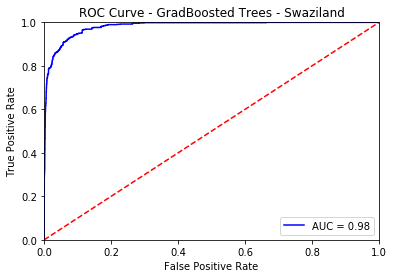

In [91]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC Curve - GradBoosted Trees - Swaziland')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig('ROC_Swaziland.png')

# Build model for Uganda

In [49]:
uganda = df[(df.country_name == 'Uganda')]

In [50]:
uganda.shape

(113667, 35)

In [51]:
uganda.isnull().sum()

country_name                    0
water_source                99313
water_tech                  12161
status_id                       0
management                  13394
pay                         73513
installer                  111615
install_year                17620
status                      13298
source                          0
adm1                        11535
adm2                        11535
wpdx_id                         0
report_date                     0
country_id                      0
activity_id                  1419
data_lnk                    12352
orig_lnk                   101043
photo_lnk                  110819
converted                   11193
created                         0
updated                         0
lat_deg                         0
lon_deg                         0
Location                        0
Count                           0
fecal_coliform_presence    113667
fecal_coliform_value       113667
subjective_quality         113667
new_report_dat

In [52]:

uganda.age_well_days.describe()

count     113667
unique      2075
top          NaT
freq       17620
Name: age_well_days, dtype: object

In [48]:
#give missing values a huge number so that the "age of the well" is hundreds of years old. The tree will see this as NA
df.loc[df.age_well_days =='NaT', 'NaT']= '999999'

In [119]:
#uganda.pay.unique() #this is text compared to Swaziland

In [120]:
#uganda.water_source.unique()

In [64]:
#encode water tech


#fill na's.  #could just do this to all of df above since XGBoost will want this
uganda.management.fillna('__MISSING__', inplace=True)
uganda.water_source.fillna('__MISSING__', inplace=True)
uganda.water_tech.fillna('__MISSING__', inplace=True)
uganda.pay.fillna('__MISSING__', inplace=True)
uganda.adm1.fillna('__MISSING__', inplace=True)
uganda.adm2.fillna('__MISSING__', inplace=True)
uganda.new_install_year.fillna('__MISSING__', inplace=True)
uganda.age_well_days.replace(to_replace='NaT', value=99999, inplace=True) #have to replace the NaTs. Using a long year 
#so the tree knows

#have to fill NA's first
lb= LabelEncoder()
pred_df = pd.DataFrame()
pred_df["water_source_code"] = lb.fit_transform(uganda["water_source"])
pred_df['water_tech_code'] = lb.fit_transform(uganda['water_tech'])


pred_df['management_code'] = lb.fit_transform(uganda['management'])
pred_df['source_code'] = lb.fit_transform(uganda['source'])
pred_df['adm1_code']= lb.fit_transform(uganda['adm1'])
pred_df['adm2_code']= lb.fit_transform(uganda['adm2'])
pred_df['pay']= lb.fit_transform(uganda['pay'])
pred_df['lat_deg']= uganda['lat_deg'].values
pred_df['lon_deg'] = uganda['lon_deg'].values
# pred_df['pay'] = uganda['pay'].values
# pred_df['pay'] = pred_df.pay.astype(float)
pred_df['new_install_year_code'] = lb.fit_transform(uganda['new_install_year'])
uganda.age_well_days.astype(int)
pred_df['age_well_years'] = uganda['age_well_days'].values

#have to cast as int now
pred_df['age_well_years'] = round(pred_df.age_well_years.astype(int)/365,1)

#target
pred_df['status_binary'] = uganda['status_binary'].values

pred_df[0:2]
#pred_df[["water_source", "water_source_code"]].head(11)


/Users/chandlermccann/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/chandlermccann/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3813: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,water_source_code,water_tech_code,management_code,source_code,adm1_code,adm2_code,pay,lat_deg,lon_deg,new_install_year_code,age_well_years,status_binary
0,36,22,12,13,121,267,168,1.33007,31.3906,87,274.0,1
1,36,22,12,13,121,267,168,1.31209,31.3887,87,274.0,1


In [112]:
###whooooops need to create a dict of my label encoded items to transform them back!!
#list(lb.classes_)

In [65]:
print(pred_df.dtypes)
pred_df.head()

water_source_code          int64
water_tech_code            int64
management_code            int64
source_code                int64
adm1_code                  int64
adm2_code                  int64
pay                        int64
lat_deg                  float64
lon_deg                  float64
new_install_year_code      int64
age_well_years           float64
status_binary              int64
dtype: object


,water_source_code,water_tech_code,management_code,source_code,adm1_code,adm2_code,pay,lat_deg,lon_deg,new_install_year_code,age_well_years,status_binary
0,36,22,12,13,121,267,168,1.33007,31.3906,87,274.0,1
1,36,22,12,13,121,267,168,1.31209,31.3887,87,274.0,1
2,36,22,12,13,121,267,168,1.23417,31.2732,87,274.0,1
3,36,22,12,13,121,267,168,2.31964,32.3859,87,274.0,1
4,36,22,12,13,121,267,168,2.43701,32.4062,87,274.0,0


In [66]:
#define X and Y
X2 = pred_df[pred_df.columns[:-1]] #age_well_days error
Y2= pred_df.status_binary

In [67]:
#use stratified K folds and gridsearch
params = {'learning_rate':[0.05,.1], 'max_depth':[3,4], 'n_estimators':[200,300],}
model_ug = model_selection.GridSearchCV(XGBClassifier(scoring='logloss'), params)
model_ug.fit(X2, Y2)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, scoring='logloss',
       seed=None, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 4], 'learning_rate': [0.05, 0.1], 'n_estimators': [200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [69]:
#logloss. prior model was 2.1 without age of the well
print(model_ug.grid_scores_)
model_ug.best_score_

[mean: 0.69734, std: 0.06653, params: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 200}, mean: 0.66222, std: 0.09101, params: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 300}, mean: 0.66452, std: 0.08820, params: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 200}, mean: 0.63601, std: 0.09113, params: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 300}, mean: 0.65197, std: 0.08775, params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200}, mean: 0.63020, std: 0.08337, params: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 300}, mean: 0.63254, std: 0.09290, params: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 200}, mean: 0.61805, std: 0.09005, params: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 300}]


/Users/chandlermccann/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


0.6973439960586626

In [106]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X2, Y2,  test_size=.2, random_state=7)

In [108]:
#get auc. need to reshape
preds_ug = model_ug.predict_proba(X_test)[:,1]
preds_uga = model_ug.predict(X_test)
#pd.DataFrame(preds2).describe()
print("Accuracy : %.4g"%metrics.accuracy_score(y_test, preds_uga))
print("AUC Score (Test): %f"%metrics.roc_auc_score(y_test, preds_ug))

Accuracy : 0.822
AUC Score (Test): 0.784920


In [102]:
preds_ug.view()

array([ 0.07418796,  0.15074968,  0.20035748, ...,  0.06849965,
        0.23815571,  0.15073991], dtype=float32)

In [103]:
1-sum(y_test)/len(y_test)

0.78367203307820887

In [104]:
# calculate the fpr and tpr for all thresholds of the classification
#probs = model.predict_proba(X_test)
#preds = probs[:,1]
fpr2, tpr2, threshold = metrics.roc_curve(y_test, preds_ug)
roc_auc2 = metrics.auc(fpr2, tpr2)

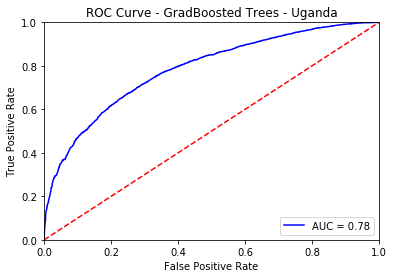

In [105]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC Curve - GradBoosted Trees - Uganda')
plt.plot(fpr2, tpr2, 'b', label = 'AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig('ROC_Uganda.png')

# Use best parameters to get feature importances for Swaziland and Uganda

In [117]:
ug_params = model_ug.best_params_
swaz_params = model2.best_params_
print(ug_params, "uganda params")
print(swaz_params, "swaziland params")

{'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 200} uganda params
{'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 300} swaziland params


In [133]:
swaz_xgb= XGBClassifier(params=swaz_params)
ug_xgb = XGBClassifier(params=ug_params)

In [121]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y,  test_size=.2, random_state=7)

In [150]:
#use 5 folds cv later, just do this to get feature importances for the class presentation
swaz_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       params={'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 300},
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [137]:
#use different feature set for Uganda, had different missing values
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X2, Y2,  test_size=.2, random_state=7)

In [138]:
ug_xgb.fit(X_train2, y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       params={'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 200},
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

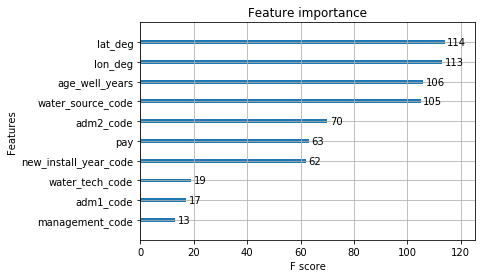

In [132]:
%matplotlib inline
xgb.plot_importance(swaz_xgb)

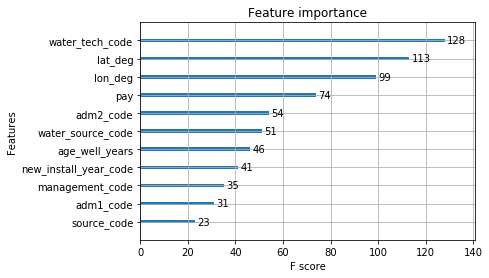

In [139]:
xgb.plot_importance(ug_xgb)

# To Do
    - Neatly show what is missing between which countries - Done
    - Convert Uganda pay to currency using regex
    - use fuzzy wuzzy to organize water source and tech - sort of done
    - run country level models on each main country
    - Time since last measurement as new variable
    - clean function to fill in missing on certain values and then handline missing age_well differently
    - create a dict of label encodings so I can transform back!! SUPER IMPORTANT
    - Analyze rows that have multiple data points for time series work and remove
    - Globally, "None" is a value and isn't "Missing", need to merge all of thme (list below)
    -***Show AUC curve for Swaziland, Uganda**** -DONE
    -***Show Feature impact for Swaziland, Uganda***- DONE
    -****Show Partial Dependence Plots for Swaziland, Uganda*** - Can't without label encoder fix
    -***Recalculate Uganda with Fuzzy Matched Columns****--DONE for tech, not source in Fuzzy notebook
    -map: water tech (India, Mark, mk,II--> India Mark2), (Bush Pump--> a,b,c- well labeled, keep), (Null, 0, None Other, no pump--> __Missing__), (Afridev has many associations), (gravity, gravity fed---> gravity), (brands--> Kabul, birka, india, afridev, nira), Stand, Tap, Bucket, 
    - map: water source (Dam river stream, borehole, dug well, tube well, shallowe well, well, 
    - addres missing values (multiple per) in Water Tech, Water Source, then do fuzzy match
    
    Contains ‘rain’ - 15,417
"""Contains ‘gravity’ - 17,022
Contains  ‘bore’ - 32,182
Contains ‘dug_well’ = 22,616
‘Shallow well’ = 17, 361
Tube well = 6368
Spring = 25,871
null/0ther = 60,000
Stand: 43, 531
Bucket: 27k
Tap: 6.7k """




    

In [148]:
print(len(swaz.water_tech.unique()))
print(len(swaz.water_source.unique()))
print(swaz.water_tech.unique())
print(swaz.water_source.unique())

16
14
['Standpipe' 'River/Stream' 'Storage Facility' 'Borehole'
 'Protected Spring' 'Slow Sand Filter' 'Control House' 'BPT'
 'Protected spring' 'Roughing Filter' 'Canal' 'Dam' 'Hand Dug Well'
 'Hand dug well' 'Pipeline' 'StandPipe']
['Borehole fitted with submersible pump' 'gravity river/stream'
 'Protected spring' 'pumped river/stream'
 'Borehole fitted with manual pump' 'Borehole' 'gravity dam'
 'Borehole fitted with Manual pump' 'gravity River/Stream'
 'Borehole fitted with no pump' 'pumped dam' 'Protected Spring' 'Canal'
 'Hand dug well']


In [147]:
print(len(uganda.water_tech.unique()))
print(len(uganda.water_source.unique()))

106
58


In [149]:
swaz.water_tech.value_counts()

Standpipe           20247
Borehole             1467
Storage Facility      968
BPT                   349
River/Stream          210
Control House         198
Protected Spring      171
StandPipe              65
Slow Sand Filter       58
Roughing Filter        29
Dam                    13
Hand Dug Well           3
Canal                   2
Pipeline                2
Protected spring        1
Hand dug well           1
Name: water_tech, dtype: int64